In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import BallTree
from sklearn.metrics import (
    mean_squared_error,
    roc_auc_score,
    r2_score,
)

import holidays

DATA_DIR = Path('../shared_data/')  # change to your local path
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# ---- 1.1 Load wildfires ----
fires_path = DATA_DIR / 'wildfires_fires.parquet'

fires = pd.read_parquet(
    fires_path,
    columns=[
        'FIRE_SIZE',
        'DISCOVERY_DATE',
        'STATE',
        'STAT_CAUSE_CODE',
        'LATITUDE',
        'LONGITUDE',
    ],
)

# Convert DISCOVERY_DATE to datetime
if not np.issubdtype(fires['DISCOVERY_DATE'].dtype, np.datetime64):
    fires['DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'])

fires = fires.rename(columns={'DISCOVERY_DATE': 'date'})

# Filter date range 1992–2015
fires = fires[
    (fires['date'].dt.year >= 1992) & (fires['date'].dt.year <= 2015)
]

# Drop rows without coordinates
fires = fires.dropna(subset=['LATITUDE', 'LONGITUDE'])
fires.head()

,FIRE_SIZE,date,STATE,STAT_CAUSE_CODE,LATITUDE,LONGITUDE
0,0.10,2005-02-02,CA,9.0,40.036944,-121.005833
1,0.25,2004-05-12,CA,1.0,38.933056,-120.404444
2,0.10,2004-05-31,CA,5.0,38.984167,-120.735556
3,0.10,2004-06-28,CA,1.0,38.559167,-119.913333
4,0.10,2004-06-28,CA,1.0,38.559167,-119.933056


# 0. Exploratory data analysis (EDA)


In this section we explore the raw wildfire and station-mapped data before building models.


We focus on:

- The distribution of distances from each fire to its nearest weather station.

- The distribution of burned area per fire (on both raw and log scales).

- Basic counts per state and over time.


In [3]:
# ---- 1.1b Attach closest weather station to each fire ----
cities_path = DATA_DIR / 'cities.csv'
stations = pd.read_csv(cities_path)

# Keep one row per station with coordinates
stations = stations[["station_id", "latitude", "longitude"]].drop_duplicates('station_id')

# Build BallTree (coordinates in radians)
station_coords = np.radians(stations[['latitude', 'longitude']].values)
fire_coords = np.radians(fires[['LATITUDE', 'LONGITUDE']].values)

tree = BallTree(station_coords, metric='haversine')
dist_rad, ind = tree.query(fire_coords, k=1)

fires['station_id'] = stations.iloc[ind.flatten()]['station_id'].values
fires['dist_to_station_km'] = dist_rad.flatten() * 6371.0  # earth radius ~6371 km

fires.head()

,FIRE_SIZE,date,STATE,STAT_CAUSE_CODE,LATITUDE,LONGITUDE,station_id,dist_to_station_km
0,0.10,2005-02-02,CA,9.0,40.036944,-121.005833,72488,143.878212
1,0.25,2004-05-12,CA,1.0,38.933056,-120.404444,72488,60.782146
2,0.10,2004-05-31,CA,5.0,38.984167,-120.735556,72483,78.251133
3,0.10,2004-06-28,CA,1.0,38.559167,-119.913333,72488,68.430576
4,0.10,2004-06-28,CA,1.0,38.559167,-119.933056,72488,68.768514


In [ ]:
# ---- 0.1 EDA: distance to nearest station and burned area ----
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have the station distance in km (computed in the previous cell)
assert 'dist_to_station_km' in fires.columns, 'dist_to_station_km missing; run the station mapping cell first.'

plt.figure(figsize=(8, 4))
sns.histplot(fires['dist_to_station_km'], bins=50, kde=True)
plt.xlabel('Distance to nearest station (km)')
plt.title('Distribution of distance from fire to nearest station')
plt.tight_layout()
plt.show()

# Raw area burned per fire
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(fires['FIRE_SIZE'], bins=100, log_scale=(False, True))
plt.xlabel('FIRE_SIZE (area burned)')
plt.ylabel('Count (log scale)')
plt.title('Distribution of raw FIRE_SIZE (per fire)')

# Log-transformed area per fire
plt.subplot(1, 2, 2)
log_fire_size = np.log1p(fires['FIRE_SIZE'])
sns.histplot(log_fire_size, bins=100, kde=True)
plt.xlabel('log1p(FIRE_SIZE)')
plt.title('Distribution of log1p(FIRE_SIZE) (per fire)')

plt.tight_layout()
plt.show()

# EDA: simple counts per state and over time
plt.figure(figsize=(10, 4))
fires['STATE'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 states by number of recorded fires')
plt.xlabel('STATE')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
fires['date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Number of fires per year')
plt.xlabel('Year')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

In [4]:
# ---- 1.2 Aggregate to station–day ----

# Basic daily targets per station
daily_agg = (
    fires.groupby(['station_id', 'date'])
    .agg(
        n_fires=('FIRE_SIZE', 'size'),
        area_burned=('FIRE_SIZE', 'sum'),
    )
    .reset_index()
)

# Cause counts per station–day (wide format)
cause_counts = (
    fires.pivot_table(
        index=['station_id', 'date'],
        columns='STAT_CAUSE_CODE',
        values='FIRE_SIZE',  # any column, we just count
        aggfunc='count',
        fill_value=0,
    )
    .rename_axis(columns='cause_code')
)

# Make nicer column names: cause_1, cause_2, ...
cause_counts.columns = [f'cause_{int(c)}' for c in cause_counts.columns]
cause_counts = cause_counts.reset_index()

# Merge counts into daily_agg
fires_daily = daily_agg.merge(
    cause_counts, on=['station_id', 'date'], how='left'
).fillna(0)

fires_daily['any_fire'] = (fires_daily['n_fires'] > 0).astype(int)
fires_daily.head()

,station_id,date,n_fires,area_burned,cause_1,cause_2,cause_3,cause_4,cause_5,cause_6,cause_7,cause_8,cause_9,cause_10,cause_11,cause_12,cause_13,any_fire
0,25563,1992-04-27,2,0.6,0,0,0,2,0,0,0,0,0,0,0,0,0,1
1,25563,1992-05-15,1,30.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,25563,1992-05-21,1,1.8,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,25563,1992-05-30,1,4.8,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,25563,1992-06-03,1,13.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [5]:
# ---- 2.1 Load weather (station-based) ----
weather_path = DATA_DIR / 'us_daily_weather_1992_2015.parquet'
weather = pd.read_parquet(weather_path)

# Ensure date is datetime
weather['date'] = pd.to_datetime(weather['date'])

# Restrict to 1992–2015
weather = weather[
    (weather['date'].dt.year >= 1992) & (weather['date'].dt.year <= 2015)
]

# Load station metadata (cities.csv)
cities_path = DATA_DIR / 'cities.csv'
cities_df = pd.read_csv(cities_path)

# Merge state info into weather via station_id
weather = weather.merge(
    cities_df[['station_id', 'state']].drop_duplicates('station_id'),
    on='station_id',
    how='left',
)

weather = weather.rename(
    columns={
        'state': 'STATE',
        'avg_temp_c': 'tavg',
        'min_temp_c': 'tmin',
        'max_temp_c': 'tmax',
        'precipitation_mm': 'prcp_1d',  # explicit 1-day precipitation
        'avg_wind_speed_kmh': 'wspd',
        'avg_sea_level_pres_hpa': 'pres',
    }
)

weather.head()

,station_id,city_name,date,season,tavg,tmin,tmax,prcp_1d,snow_depth_mm,avg_wind_dir_deg,wspd,peak_wind_gust_kmh,pres,sunshine_total_min,STATE
0,72518,Albany,1992-01-01,Winter,-8.3,-15.0,1.1,0.0,0.0,NaN,1.4,13.0,1035.9,546.0,New York
1,72518,Albany,1992-01-02,Winter,NaN,-13.3,1.1,0.0,0.0,NaN,3.2,16.6,NaN,221.0,New York
2,72518,Albany,1992-01-03,Winter,1.8,-3.3,7.2,0.0,0.0,NaN,3.6,13.0,1027.5,227.0,New York
3,72518,Albany,1992-01-04,Winter,1.7,-3.3,3.9,9.4,0.0,NaN,10.1,25.9,1018.5,0.0,New York
4,72518,Albany,1992-01-05,Winter,3.6,1.7,5.6,0.0,0.0,336.0,15.1,38.9,1009.7,24.0,New York


In [6]:
# ---- 2.2 Aggregate station data to station–day ----
weather_daily = (
    weather.groupby(['station_id', 'date'])
    .agg(
        tavg=('tavg', 'mean'),
        tmin=('tmin', 'mean'),
        tmax=('tmax', 'mean'),
        prcp_1d=('prcp_1d', 'sum'),  # daily precip (1-day)
        wspd=('wspd', 'mean'),
        pres=('pres', 'mean'),
        STATE=('STATE', 'first'),
    )
    .reset_index()
)

weather_daily.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE
0,70381,1992-01-01,3.8,3.3,4.4,13.2,31.7,NaN,Alaska
1,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,NaN,Alaska
2,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,NaN,Alaska
3,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,NaN,Alaska
4,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,NaN,Alaska


In [7]:
# ---- 2.3 Add lagged weather features (per station) ----
def add_lagged_features(
    df,
    group_col,
    date_col,
    base_cols,
    windows=(3, 7, 30),
    shift=1,
):
    """
    For each base_col, compute rolling means or sums over given windows,
    then shift by `shift` days to avoid using same-day info.
    """
    df = df.sort_values([group_col, date_col]).copy()

    for col in base_cols:
        for w in windows:
            roll = (
                df.groupby(group_col)[col]
                .transform(lambda x: x.rolling(w, min_periods=1).mean())
            )
            df[f'{col}_mean_{w}'] = roll.shift(shift)

    # Cumulative precipitation over 7 and 30 days, based on 1-day precip
    for w in [7, 30]:
        roll = (
            df.groupby(group_col)['prcp_1d']
            .transform(lambda x: x.rolling(w, min_periods=1).sum())
        )
        df[f'prcp_1d_sum_{w}'] = roll.shift(shift)

    return df

weather_feat = weather_daily.copy()

# Impute any remaining NaNs before building lags (per station)
weather_feat = weather_feat.set_index('station_id')
weather_feat = weather_feat.groupby(level=0).ffill().bfill()
weather_feat = weather_feat.reset_index()

weather_feat['year'] = weather_feat['date'].dt.year
weather_feat['month'] = weather_feat['date'].dt.month
weather_feat['doy'] = weather_feat['date'].dt.dayofyear

base_cols = ['tavg', 'tmin', 'tmax', 'prcp_1d', 'wspd', 'pres']

weather_feat = add_lagged_features(
    weather_feat,
    group_col='station_id',
    date_col='date',
    base_cols=base_cols,
)

# Drop first few rows where lags are NaN (from shift)
weather_feat = weather_feat.dropna().reset_index(drop=True)

weather_feat.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE,year,...,prcp_1d_mean_7,prcp_1d_mean_30,wspd_mean_3,wspd_mean_7,wspd_mean_30,pres_mean_3,pres_mean_7,pres_mean_30,prcp_1d_sum_7,prcp_1d_sum_30
0,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,1018.5,Alaska,1992,...,13.200,13.200,31.700000,31.700000,31.700000,1018.5,1018.5,1018.5,13.2,13.2
1,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,1018.5,Alaska,1992,...,7.850,7.850,26.650000,26.650000,26.650000,1018.5,1018.5,1018.5,15.7,15.7
2,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,1018.5,Alaska,1992,...,5.900,5.900,21.833333,21.833333,21.833333,1018.5,1018.5,1018.5,17.7,17.7
3,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,1018.5,Alaska,1992,...,4.425,4.425,15.000000,19.175000,19.175000,1018.5,1018.5,1018.5,17.7,17.7
4,70381,1992-01-06,1.0,-0.6,2.2,0.5,10.8,1018.5,Alaska,1992,...,4.140,4.140,16.666667,20.660000,20.660000,1018.5,1018.5,1018.5,20.7,20.7


In [8]:
# ---- 3.1 Merge weather and fires on station + date + calendar / holiday features ----
data = weather_feat.merge(
    fires_daily, on=['station_id', 'date'], how='left'
)

# Replace NaNs in fire-related columns with 0
fire_cols = [c for c in data.columns if c.startswith('cause_')] + [
    'n_fires', 'area_burned', 'any_fire',
]
for c in fire_cols:
    if c in data.columns:
        data[c] = data[c].fillna(0)

# Transformed target for area
data['log_area_burned'] = np.log1p(data['area_burned'])

# Weekend indicator
data['is_weekend'] = data['date'].dt.weekday.isin([5, 6]).astype(int)

# US holidays
us_holidays = holidays.US()
data['holiday_name'] = data['date'].dt.date.map(us_holidays.get)
data['is_holiday'] = data['holiday_name'].notna().astype(int)
data['is_july4'] = (data['holiday_name'] == 'Independence Day').astype(int)

# Combined "weekend or holiday" flag (optional extra feature)
data['is_weekend_or_holiday'] = (
    (data['is_weekend'] == 1) | (data['is_holiday'] == 1)
).astype(int)

data.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE,year,...,cause_11,cause_12,cause_13,any_fire,log_area_burned,is_weekend,holiday_name,is_holiday,is_july4,is_weekend_or_holiday
0,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0
1,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0
2,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,1,None,0,0,1
3,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,1,None,0,0,1
4,70381,1992-01-06,1.0,-0.6,2.2,0.5,10.8,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0


In [9]:
# ---- 4.1 Encode STATE and station_id ----
le_state = LabelEncoder()
data['STATE_LE'] = le_state.fit_transform(
    data['STATE'].fillna('UNK').astype(str)
 )

le_station = LabelEncoder()
data['station_LE'] = le_station.fit_transform(
    data['station_id'].astype(str)
 )

# ---- 4.2 Final feature list (excluding targets) ----
exclude_cols = {
    'n_fires',
    'any_fire',
    'area_burned',
    'log_area_burned',
    'STATE',
    'station_id',
    'date',
    'holiday_name',  # drop string column so all features are numeric
} | set([c for c in data.columns if c.startswith('cause_')])

feature_cols = [c for c in data.columns if c not in exclude_cols]
len(feature_cols), feature_cols[:10]

(35,
 ['tavg',
  'tmin',
  'tmax',
  'prcp_1d',
  'wspd',
  'pres',
  'year',
  'month',
  'doy',
  'tavg_mean_3'])

In [10]:
# ---- 5.1 Train / test split by year ----
train_year_cutoff = 2011
train_mask = data['year'] < train_year_cutoff
test_mask = ~train_mask

X_train = data.loc[train_mask, feature_cols]
X_test = data.loc[test_mask, feature_cols]

y_train_count = data.loc[train_mask, 'n_fires']
y_test_count = data.loc[test_mask, 'n_fires']

y_train_bin = data.loc[train_mask, 'any_fire']
y_test_bin = data.loc[test_mask, 'any_fire']

y_train_log_area = data.loc[train_mask, 'log_area_burned']
y_test_log_area = data.loc[test_mask, 'log_area_burned']

In [11]:
# ---- 6.1 Count model (Poisson) ----
lgb_train = lgb.Dataset(X_train, label=y_train_count)
lgb_valid = lgb.Dataset(X_test, label=y_test_count)

params_count = {
    'objective': 'poisson',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'rmse',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_STATE,
}

model_count = lgb.train(
    params_count,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_valid],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)],
)

pred_count = model_count.predict(X_test, num_iteration=model_count.best_iteration)
rmse_count = np.sqrt(mean_squared_error(y_test_count, pred_count))

print(f'Count model RMSE: {rmse_count:.3f}')
print(f'Mean actual count in test: {y_test_count.mean():.3f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6636
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 35
[LightGBM] [Info] Start training from score 1.392832
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 6.17689
[100]	valid_0's rmse: 6.17689
[200]	valid_0's rmse: 6.07038
[200]	valid_0's rmse: 6.07038
[300]	valid_0's rmse: 5.9926
[300]	valid_0's rmse: 5.9926
[400]	valid_0's rmse: 5.95084
[400]	valid_0's rmse: 5.95084
[500]	valid_0's rmse: 5.93037
[500]	valid_0's rmse: 5.93037
[600]	valid_0's rmse: 5.91558
[600]	valid_0's rmse: 5.91558
[700]	valid_0's rmse: 5.89881
[700]	valid_0's rmse: 5.89881
[800]	valid_0's rmse: 5.89502
[800]	valid_0's rmse: 5.89502
[900]	valid_0's rmse: 5.88362
[900]	valid_0's rmse: 5

In [12]:
# ---- 6.2 Binary any-fire model (for AUC) ----
params_bin = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'auc',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_STATE,
}

lgb_train_bin = lgb.Dataset(X_train, label=y_train_bin)
lgb_valid_bin = lgb.Dataset(X_test, label=y_test_bin)

model_bin = lgb.train(
    params_bin,
    lgb_train_bin,
    num_boost_round=2000,
    valid_sets=[lgb_valid_bin],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)],
)

prob_any_fire = model_bin.predict(
    X_test, num_iteration=model_bin.best_iteration
)
auc_any_fire = roc_auc_score(y_test_bin, prob_any_fire)

print(f'AUC (any_fire): {auc_any_fire:.3f}')
print(f'Positive rate (fires on a day): {y_test_bin.mean():.3f}')

[LightGBM] [Info] Number of positive: 157497, number of negative: 177930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6636
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 35
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469542 -> initscore=-0.121984
[LightGBM] [Info] Start training from score -0.121984
Training until validation scores don't improve for 100 rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469542 -> initscore=-0.121984
[LightGBM] [Info] Start training from score -0.121984
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.883197
[100]	valid_0's auc: 0.883197
[200]	valid_0's auc: 0.889654
[200]	valid_0's auc: 0.889654
[300]	valid_0's auc: 0.891175
[

In [13]:
# ---- 7.1 Area model ----
params_area = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'rmse',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_STATE,
}

lgb_train_area = lgb.Dataset(X_train, label=y_train_log_area)
lgb_valid_area = lgb.Dataset(X_test, label=y_test_log_area)

model_area = lgb.train(
    params_area,
    lgb_train_area,
    num_boost_round=2000,
    valid_sets=[lgb_valid_area],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)],
)

pred_log_area = model_area.predict(
    X_test, num_iteration=model_area.best_iteration
)

rmse_log_area = np.sqrt(mean_squared_error(
    y_test_log_area, pred_log_area
))
r2_log_area = r2_score(y_test_log_area, pred_log_area)

print(f'Area model RMSE (log1p): {rmse_log_area:.3f}')
print(f'Area model R^2 (log1p): {r2_log_area:.3f}')

# Baseline: predict mean log-area of train
baseline_log = np.full_like(y_test_log_area, y_train_log_area.mean())
baseline_rmse_log = np.sqrt(mean_squared_error(
    y_test_log_area, baseline_log
))
print(f'Baseline RMSE (log1p mean): {baseline_rmse_log:.3f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6636
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 35
[LightGBM] [Info] Start training from score 1.190421
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.35606
[100]	valid_0's rmse: 1.35606
[200]	valid_0's rmse: 1.33304
[200]	valid_0's rmse: 1.33304
[300]	valid_0's rmse: 1.3257
[300]	valid_0's rmse: 1.3257
[400]	valid_0's rmse: 1.32326
[400]	valid_0's rmse: 1.32326
[500]	valid_0's rmse: 1.32232
[500]	valid_0's rmse: 1.32232
[600]	valid_0's rmse: 1.32108
[600]	valid_0's rmse: 1.32108
[700]	valid_0's rmse: 1.32151
[700]	valid_0's rmse: 1.32151
Early stopping, best iteration is:
[667]	valid_0's rmse: 1.32058
Early stopping, best iteration is:
[667]	valid_0's rmse: 1.32058
Area model RMSE (log1p): 1.321
Area model R^2 (

In [14]:
# ---- 8.1 Prepare cause targets ----
cause_cols = [c for c in data.columns if c.startswith('cause_')]
len(cause_cols), cause_cols

# Keep only days with at least one fire
data_cause = data[data['n_fires'] > 0].copy()

# Proportions per cause
for c in cause_cols:
    data_cause[c + '_prop'] = data_cause[c] / data_cause['n_fires']

target_prop_cols = [c + '_prop' for c in cause_cols]

# Train/test split by year (same cutoff)
train_mask_cause = data_cause['year'] < train_year_cutoff
test_mask_cause = ~train_mask_cause

X_train_cause = data_cause.loc[train_mask_cause, feature_cols]
X_test_cause = data_cause.loc[test_mask_cause, feature_cols]

Y_train_cause = data_cause.loc[train_mask_cause, target_prop_cols].values
Y_test_cause = data_cause.loc[test_mask_cause, target_prop_cols].values

In [15]:
# ---- 8.2 Multi-output regression for cause proportions ----
base_reg = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=64,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
)

multi_reg = MultiOutputRegressor(base_reg)
multi_reg.fit(X_train_cause, Y_train_cause)

Y_pred_cause = multi_reg.predict(X_test_cause)

# Ensure non-negative and normalize to sum to 1
Y_pred_cause = np.clip(Y_pred_cause, 0, None)
row_sums = Y_pred_cause.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
Y_pred_cause = Y_pred_cause / row_sums

# ---- 8.3 Metrics: MSE of proportions and cross-entropy per fire ----
mse_props = mean_squared_error(Y_test_cause.reshape(-1), Y_pred_cause.reshape(-1))
print(f'MSE on cause proportions: {mse_props:.5f}')

eps = 1e-12
ce_per_day = -np.sum(Y_test_cause * np.log(Y_pred_cause + eps), axis=1)
ce_mean = ce_per_day.mean()
print(f'Mean cross-entropy (per day, per fire): {ce_mean:.3f}')

# Baseline: always predict global average cause distribution (from train)
global_dist = Y_train_cause.sum(axis=0)
global_dist = global_dist / global_dist.sum()

baseline_pred = np.tile(global_dist, (Y_test_cause.shape[0], 1))
ce_baseline = -np.sum(Y_test_cause * np.log(baseline_pred + eps), axis=1).mean()
mse_baseline = mean_squared_error(
    Y_test_cause.reshape(-1), baseline_pred.reshape(-1)
)

print(f'Baseline CE: {ce_baseline:.3f}')
print(f'Baseline MSE: {mse_baseline:.5f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6590
[LightGBM] [Info] Number of data points in the train set: 157497, number of used features: 35
[LightGBM] [Info] Start training from score 0.105416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6590
[LightGBM] [Info] Number of data points in the train set: 157497, number of used features: 35
[LightGBM] [Info] Start training from score 0.080617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6590
[LightGBM] [Info] Number of data points in the train set: 157497, number of used features: 35
[LightGBM] [Info] Start 

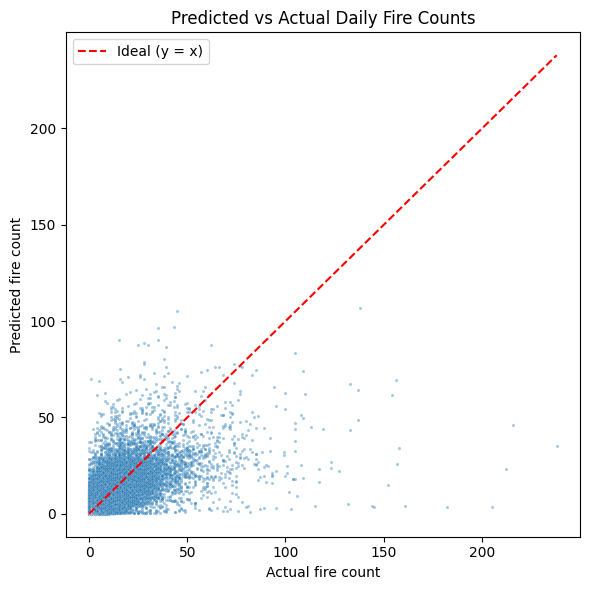

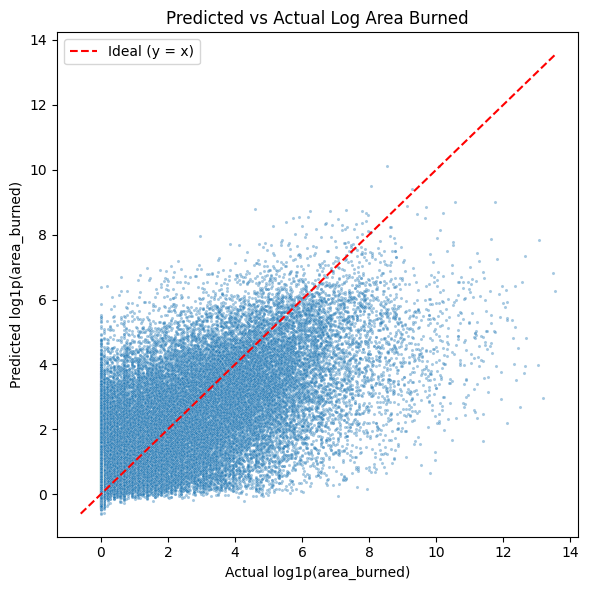

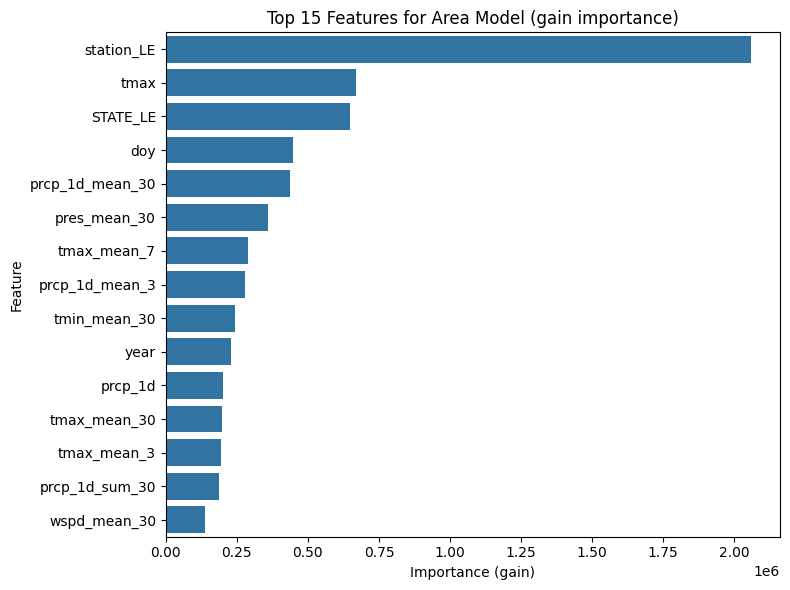

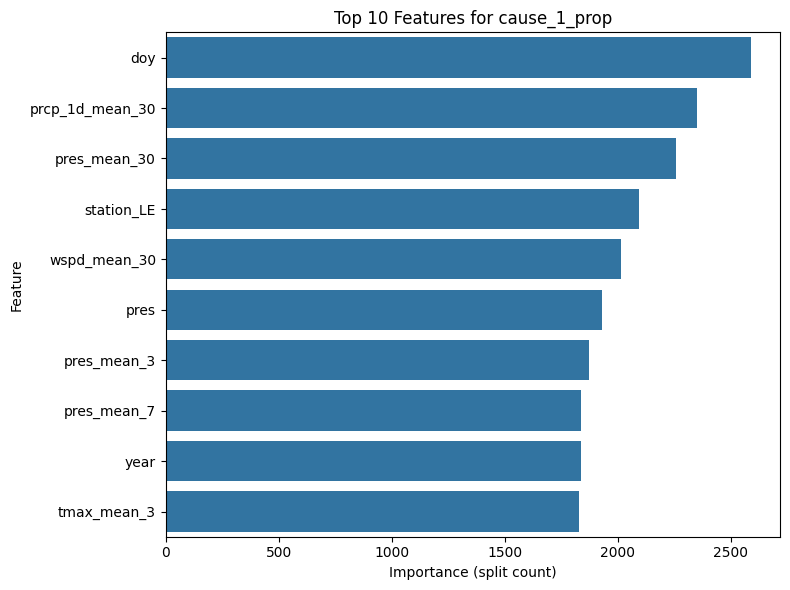

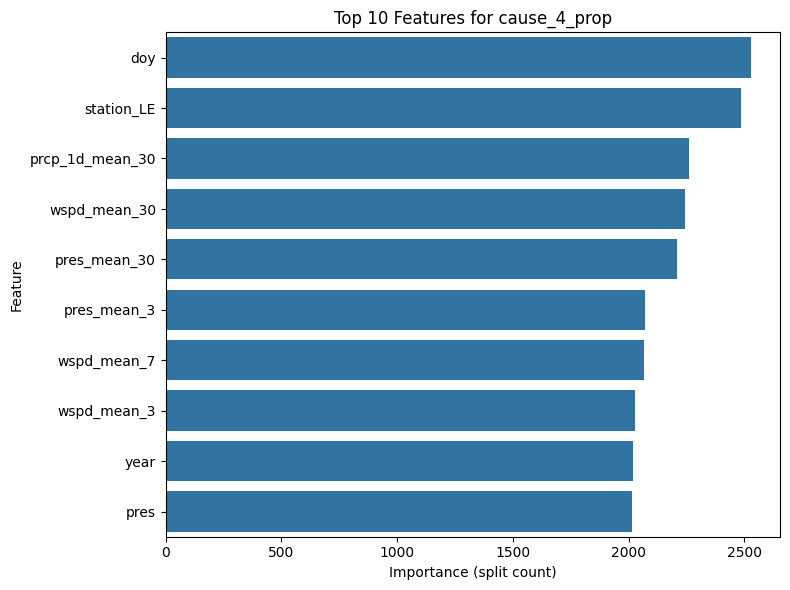

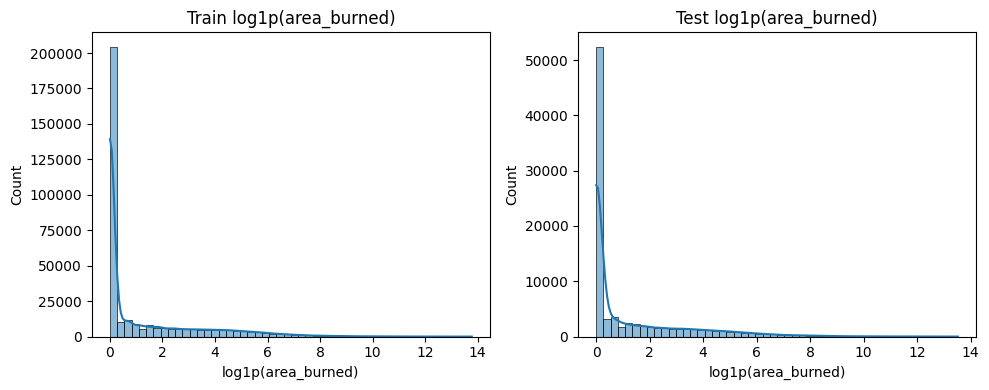

Train log-area:
count    335427.000000
mean          1.190421
std           1.970460
min           0.000000
25%           0.000000
50%           0.000000
75%           1.791759
max          13.782257
Name: log_area_burned, dtype: float64

Test log-area:
count    88738.000000
mean         1.193203
std          1.959292
min          0.000000
25%          0.000000
50%          0.029559
75%          1.791759
max         13.528744
Name: log_area_burned, dtype: float64


In [17]:
# ---- 9.1 Predicted vs Actual fire counts ----
# Assumes y_test_count and pred_count are available from earlier cells
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_count, y=pred_count, s=5, alpha=0.4)
max_val = max(y_test_count.max(), pred_count.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal (y = x)')
plt.xlabel('Actual fire count')
plt.ylabel('Predicted fire count')
plt.title('Predicted vs Actual Daily Fire Counts')
plt.legend()
plt.tight_layout()
plt.show()

# ---- 9.2 Predicted vs Actual log area burned ----
# Assumes y_test_log_area and pred_log_area are available
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_log_area, y=pred_log_area, s=5, alpha=0.4)
min_val = min(y_test_log_area.min(), pred_log_area.min())
max_val = max(y_test_log_area.max(), pred_log_area.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')
plt.xlabel('Actual log1p(area_burned)')
plt.ylabel('Predicted log1p(area_burned)')
plt.title('Predicted vs Actual Log Area Burned')
plt.legend()
plt.tight_layout()
plt.show()

# ---- 9.3 Feature importance for area model ----
# Use LightGBM's built-in feature importance for model_area
importances_area = model_area.feature_importance(importance_type='gain')
feature_importance_area = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances_area,
})
feature_importance_area = feature_importance_area.sort_values('importance', ascending=False)
top_n = 15
top_features_area = feature_importance_area.head(top_n)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_features_area, x='importance', y='feature', orient='h')
plt.title(f'Top {top_n} Features for Area Model (gain importance)')
plt.xlabel('Importance (gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ---- 9.4 Feature importance for specific causes (cause_1_prop and cause_4_prop) ----
# Extract individual regressors from multi_reg
# Assumes target_prop_cols corresponds to order of outputs in multi_reg
cause_names = ['cause_1_prop', 'cause_4_prop']
for cause_name in cause_names:
    if cause_name not in target_prop_cols:
        print(f"Warning: {cause_name} not found in target_prop_cols; skipping.")
        continue

    idx = target_prop_cols.index(cause_name)
    reg = multi_reg.estimators_[idx]  # lightgbm.LGBMRegressor instance

    fi = reg.feature_importances_
    fi_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': fi,
    }).sort_values('importance', ascending=False)
    top_k = 10
    top_fi = fi_df.head(top_k)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=top_fi, x='importance', y='feature', orient='h')
    plt.title(f'Top {top_k} Features for {cause_name}')
    plt.xlabel('Importance (split count)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# ---- 9.5 Distributions of log area burned ----
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_train_log_area, bins=50, kde=True)
plt.title('Train log1p(area_burned)')
plt.xlabel('log1p(area_burned)')

plt.subplot(1, 2, 2)
sns.histplot(y_test_log_area, bins=50, kde=True)
plt.title('Test log1p(area_burned)')
plt.xlabel('log1p(area_burned)')

plt.tight_layout()
plt.show()

print('Train log-area:')
print(y_train_log_area.describe())
print('\nTest log-area:')
print(y_test_log_area.describe())

# Feature and target glossary


This section summarizes the main engineered features and targets used in this notebook.



## Identifiers and time fields


- `station_id`: ID of the nearest weather station associated with each fire and each daily weather record.

- `STATE`: Two-letter US state abbreviation for the station.

- `date`: Calendar date (day-level granularity) for each station-day.

- `year`, `month`, `doy`: Calendar year, month (1–12), and day-of-year (1–366) derived from `date`.



## Weather features (daily aggregates)



Base daily weather variables aggregated per station and date:



- `tavg`: Mean daily temperature (°C).

- `tmin`: Minimum daily temperature (°C).

- `tmax`: Maximum daily temperature (°C).

- `prcp_1d`: Total daily precipitation (mm) for that day.

- `wspd`: Average daily wind speed (km/h).

- `pres`: Average daily sea-level pressure (hPa).



## Lagged and windowed weather features



To avoid look-ahead bias, rolling features are computed within each station, then shifted by 1 day so only **past** weather is used to predict fires on a given day.



For each base column in `[tavg, tmin, tmax, prcp_1d, wspd, pres]` and for window sizes 3, 7, and 30 days:



- `<col>_mean_3`, `<col>_mean_7`, `<col>_mean_30`  

  Rolling mean of the last 3, 7, or 30 days of that variable, shifted by 1 day.



For precipitation specifically:



- `prcp_1d_sum_7`, `prcp_1d_sum_30`  

  Rolling sum of daily precipitation over the last 7 or 30 days (also shifted by 1 day).



These lags capture short- and medium-term weather patterns leading up to potential fires.



## Calendar and holiday features



- `is_weekend`: 1 if `date` is Saturday or Sunday, otherwise 0.

- `is_holiday`: 1 if the date is a US federal holiday (from the `holidays` library), otherwise 0.

- `is_july4`: 1 if the date is **Independence Day**, otherwise 0.  

  This is a proxy for increased fire risk driven by fireworks.

- `is_weekend_or_holiday`: 1 if either `is_weekend` or `is_holiday` is 1, otherwise 0.



These features capture human behavior patterns (weekends, holidays, July 4) that can influence ignition risk.



## Encoded identifiers



- `STATE_LE`: Integer label encoding of `STATE` (state-level categorical information).

- `station_LE`: Integer label encoding of `station_id` (station identity).



These are used as numeric proxies for location in the models.



## Fire activity targets and cause counts



Station-day fire aggregates:



- `n_fires`: Number of fires discovered on that station-day.

- `area_burned`: Sum of `FIRE_SIZE` (area burned) across all fires on that station-day.

- `any_fire`: Binary indicator equal to 1 if at least one fire occurred (`n_fires > 0`), 0 otherwise.



Cause-specific daily counts (from pivoting `STAT_CAUSE_CODE`):



- `cause_1`, `cause_2`, ..., `cause_k`: Count of fires on that day attributed to each cause code `k`.



For the cause-proportion model (only on days with fires):



- `cause_<k>_prop`: Proportion of fires on that day attributed to cause code `k`, i.e.  

  `cause_<k>_prop = cause_<k> / n_fires`.



These per-cause proportions are used as multi-output regression targets in the `multi_reg` LightGBM model.



## Transformed area target



- `log_area_burned`: `log1p(area_burned)`  

  A log-transform of total burned area to stabilize variance and reduce the impact of very large fires.  

  This is the target for the **area model** (`model_area`).



### Train/test targets used in models



- `y_train_count`, `y_test_count`: Training and test labels for the **count model** (predicting `n_fires`).

- `y_train_bin`, `y_test_bin`: Training and test labels for the **binary any-fire model** (predicting `any_fire`).

- `y_train_log_area`, `y_test_log_area`: Training and test labels for the **area model** (predicting `log_area_burned`).



Together, these features and targets allow the notebook to model:



1. How many fires occur on a given station-day.

2. Whether any fire occurs at all.

3. How much area burns (on a log scale).

4. How the mix of ignition causes varies with weather, calendar, and location.
